# Strategy Description: Commodity Cross-Sectional Momentum

### 1. Executive Summary
This strategy applies a **Cross-Sectional Momentum** approach to Gold and Silver.

The core premise is that commodities with strong recent performance (Winners) tend to continue outperforming those with weak performance (Losers), often driven by the "Roll Yield" component (backwardation vs. contango).

### 2. Strategy Logic

#### A. Signal Generation (Ranking)
The strategy calculates a **Momentum Score** for both assets based on their logarithmic returns over a specific lookback window.
* **Lookback Period:** 20 Days (approx. 5,520 bars).
* **Comparison:** At the rebalancing time, the strategy compares the momentum of Gold vs. Silver.

#### B. Position Taking (Long/Short)
The strategy constructs a **Long/Short portfolio** based on the relative strength:
* **Scenario 1 (Gold > Silver):** Buy 1 Unit of Gold / Sell 1 Unit of Silver.
* **Scenario 2 (Silver > Gold):** Buy 1 Unit of Silver / Sell 1 Unit of Gold.
* *Note:* The strategy is always in the market (Long/Short) unless the data period is designated as Out-of-Sample.

#### C. Rebalancing
* **Frequency:** Daily (every 276 bars).
* **Rationale:** Rebalancing is restricted to once a day to minimize transaction costs and avoid "noise" inherent in 5-minute data.

### 3. Risk Management & Constraints

* **Position Sizing:**
    Strictly limited to **1 Unit per asset**. This avoids over-leveraging and keeps the logic purely focused on directional accuracy rather than sizing optimization.
* **Out-of-Sample (OOS) Handling:**
    To ensure robust testing, trading is strictly prohibited during OOS periods. Positions are forced to **Flat (0)** during these gaps to prevent data leakage and unrealistic equity curve interpolation.

### 4. Performance Metrics
Performance is evaluated on a daily aggregated basis, separated by Quarter, using the following metrics:

* **Sharpe Ratio (Gross/Net):** Risk-adjusted return (Annualized).
* **Calmar Ratio (Gross/Net):** Return relative to Maximum Drawdown (Annualized).
* **Cumulative P&L:** Total monetary profit/loss.
* **Transaction Costs:** Explicitly deducted (Spread + Commission) to calculate Net metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # Strategy Parameters
    MOMENTUM_WINDOW = 276 * 20
    REBALANCE_FREQ = 276
    ANNUALIZATION = 252

In [3]:
# ==========================================
# 2. Data Preparation
# ==========================================
def prepare_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    print("Calculating Momentum per Quarter...")

    def calc_mom(group):
        if len(group) < cfg.MOMENTUM_WINDOW:
            group['XAU_Mom'] = np.nan
            group['XAG_Mom'] = np.nan
        else:
            group['XAU_Mom'] = np.log(group['XAU'] / group['XAU'].shift(cfg.MOMENTUM_WINDOW))
            group['XAG_Mom'] = np.log(group['XAG'] / group['XAG'].shift(cfg.MOMENTUM_WINDOW))
        return group

    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)
    data.dropna(subset=['XAU_Mom', 'XAG_Mom'], inplace=True)

    return data

In [4]:


# ==========================================
# 3. Strategy Logic
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    dates = data.index
    mom_xau = data['XAU_Mom'].values
    mom_xag = data['XAG_Mom'].values
    in_sample = data['Is_In_Sample'].values

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)

    curr_pos_xau = 0
    curr_pos_xag = 0

    print("Simulating Strategy (1 Unit Constraint)...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        if i % cfg.REBALANCE_FREQ == 0:
            m_xau = mom_xau[i]
            m_xag = mom_xag[i]

            if m_xau > m_xag:
                curr_pos_xau = 1
                curr_pos_xag = -1
            else:
                curr_pos_xau = -1
                curr_pos_xag = 1

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0)

    return data





In [5]:
# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()

    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'] + df['Gross_PnL_XAG']

    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + \
                       (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats

In [6]:
# ==========================================
# 5. Performance Stats (Per Quarter) - FIX APPLIED
# ==========================================
def generate_quarterly_report(daily_df, cfg):
    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    print(f"{'='*80}")
    print(f" PERFORMANCE REPORT (Daily Aggregation) - 1 Unit Fixed Strategy")
    print(f"{'='*80}")

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        # Cum P&L
        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio
        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        # Calmar Ratio
        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        annualized_pnl_g = gross_cum_pnl / years if years > 0 else 0
        gross_cr = (annualized_pnl_g / max_dd_g) if max_dd_g > 0 else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        annualized_pnl_n = net_cum_pnl / years if years > 0 else 0
        net_cr = (annualized_pnl_n / max_dd_n) if max_dd_n > 0 else 0

        # Trades
        av_ntrades = d_q['Total_Trades'].mean()

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Av. Trades': av_ntrades
        })

    stats_df = pd.DataFrame(stats_list)

    format_dict = {
        'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
        'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
        'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
        'Av. Trades': '{:.1f}'
    }

    display(stats_df.style.format(format_dict).background_gradient(subset=['Net CumP&L'], cmap='RdYlGn'))

    # 【修正箇所】daily_stats ではなく引数の daily_df を返す
    return stats_df, daily_df



In [7]:
# ==========================================
# 6. Visualization
# ==========================================
def plot_quarterly_equity(daily_stats):
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Net Cumulative P&L (Daily Aggregated) - Gap Handled')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



Calculating Momentum per Quarter...
Simulating Strategy (1 Unit Constraint)...
 PERFORMANCE REPORT (Daily Aggregation) - 1 Unit Fixed Strategy


/var/folders/3h/3r1g6ccn01v_37rgl_0q98rw0000gn/T/ipykernel_12315/2358093351.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)


,Quarter,Gross SR,Net SR,Gross CR,Net CR,Gross CumP&L,Net CumP&L,Av. Trades
0,2023_Q1,3.89,3.87,14.63,14.55,"$13,125","$13,050",0.1
1,2023_Q3,-5.18,-5.22,-3.70,-3.71,"$-19,082","$-19,232",0.2
2,2023_Q4,-0.47,-0.54,-0.83,-0.95,"$-2,495","$-2,895",0.6
3,2024_Q2,0.41,0.35,0.92,0.80,"$3,197","$2,797",0.6
4,2024_Q4,0.82,0.78,2.41,2.23,"$7,726","$7,326",0.6
5,2025_Q1,-3.08,-3.14,-3.22,-3.25,"$-15,513","$-15,863",0.5
6,2025_Q2,-0.22,-0.24,-0.79,-0.83,"$-3,132","$-3,332",0.3


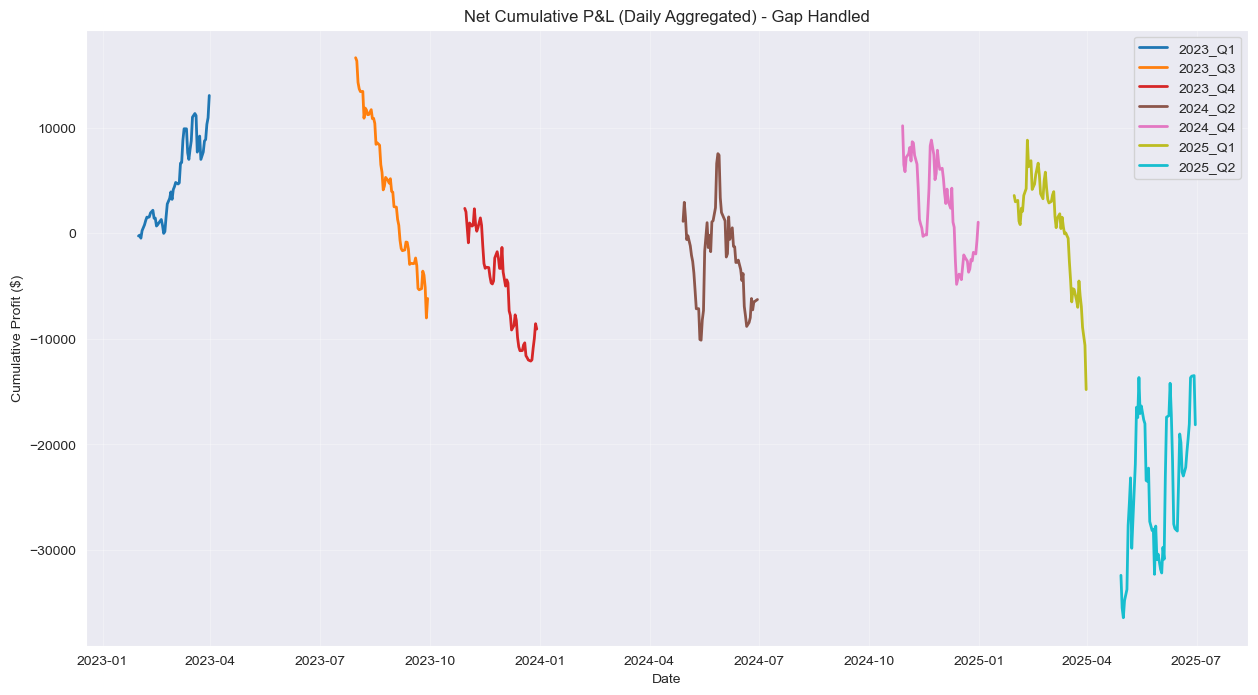

In [8]:
# ==========================================
# 7. Execution
# ==========================================
cfg = Config()
df_prep = prepare_data(cfg.FILE_PATH, cfg)

if df_prep is not None:
    # Run Strategy
    df_res = run_strategy(df_prep, cfg)

    # Calculate Daily Metrics
    daily_data = calculate_metrics(df_res, cfg)

    # Generate Report
    stats_table, daily_with_equity = generate_quarterly_report(daily_data, cfg)

    # Plot
    plot_quarterly_equity(daily_with_equity)

Data loaded successfully. Total rows: 122791

1. Daily Bar Count Verification
Average bars per day: 224.89
Median bars per day:  272
Max bars in a day:    272
Min bars in a day:    58

Most Common Bar Counts (Top 5):
272    327
202     82
70      81
271     12
193      7
Name: count, dtype: int64

2. Gap/Buffer Zone Verification (16:50 - 18:10)
✅ SUCCESS: No data found in the restricted buffer zone (16:50 - 18:10).

3. Session Start/End Time Check
Most common START times:
00:00:00    451
18:10:00     84
16:05:00      7
Name: count, dtype: int64

Most common END times:
23:55:00    453
16:45:00     85
16:00:00      7
Name: count, dtype: int64


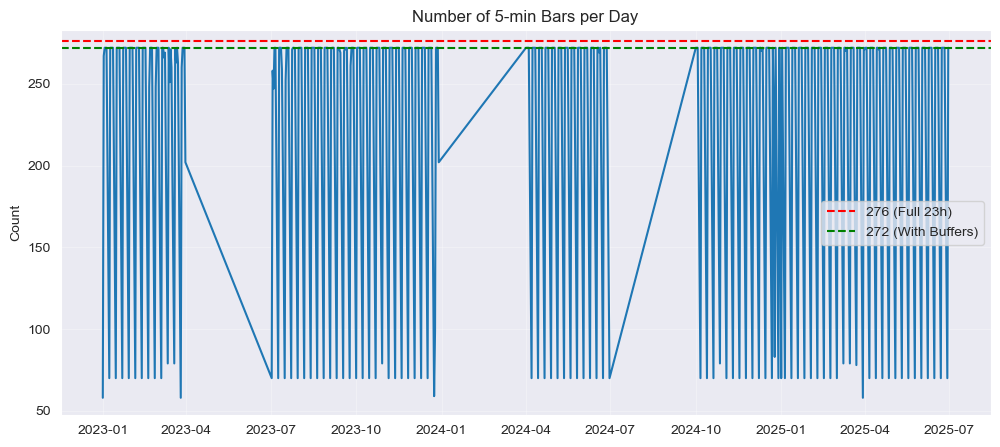

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 設定
# ==========================================
FILE_PATH = '../preprocess/df_g2_processed.pkl'

def verify_data_structure(file_path):
    # 1. データ読み込み
    try:
        df = pd.read_pickle(file_path)
        print(f"Data loaded successfully. Total rows: {len(df)}")
    except FileNotFoundError:
        print("Error: File not found.")
        return

    # インデックスがDatetime型か確認
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # ==========================================
    # 検証1: 1日あたりの足の本数を確認
    # ==========================================
    print("\n" + "="*40)
    print("1. Daily Bar Count Verification")
    print("="*40)

    # 日付ごとにグループ化してカウント
    # タイムゾーンやセッション区切りを考慮し、単純に日付(date)で集計
    daily_counts = df.groupby(df.index.date).size()

    # 統計情報の表示
    print(f"Average bars per day: {daily_counts.mean():.2f}")
    print(f"Median bars per day:  {daily_counts.median():.0f}")
    print(f"Max bars in a day:    {daily_counts.max()}")
    print(f"Min bars in a day:    {daily_counts.min()}")

    # 分布（最頻値）を確認
    print("\nMost Common Bar Counts (Top 5):")
    print(daily_counts.value_counts().head(5))

    # ==========================================
    # 検証2: 禁止時間帯の混入チェック
    # ==========================================
    print("\n" + "="*40)
    print("2. Gap/Buffer Zone Verification (16:50 - 18:10)")
    print("="*40)

    # チェック対象の時間を定義
    # 16:50 <= time < 18:10 の範囲にデータがあるかチェック
    # ※5分足のタイムスタンプが「足の開始時間」と仮定

    times = df.index.time

    # 禁止時間帯の定義 (文字列表現で比較)
    # 16:50:00 〜 18:05:00 (18:10開始の足はOK)
    start_gap = pd.Timestamp("16:50:00").time()
    end_gap   = pd.Timestamp("18:10:00").time()

    # 通常、日付を跨ぐため、条件を分けて抽出
    # ケース: 16:50以降 〜 23:59 または 00:00 〜 18:10未満
    # しかしCMEの休場は日付を跨がない（17:00-18:00 EST）ことが多いですが、
    # データセットのタイムゾーンによります。ここでは単純に時刻でフィルタします。

    gap_mask = (times >= start_gap) & (times < end_gap)
    gap_data = df[gap_mask]

    if len(gap_data) == 0:
        print("✅ SUCCESS: No data found in the restricted buffer zone (16:50 - 18:10).")
    else:
        print(f"⚠️ WARNING: Found {len(gap_data)} rows inside the restricted zone!")
        print("Sample timestamps in gap:")
        print(gap_data.index[:5])

    # ==========================================
    # 検証3: セッション開始・終了時刻の確認
    # ==========================================
    print("\n" + "="*40)
    print("3. Session Start/End Time Check")
    print("="*40)

    # 各日の最初の時刻と最後の時刻を集計
    daily_starts = df.groupby(df.index.date).apply(lambda x: x.index[0].time())
    daily_ends   = df.groupby(df.index.date).apply(lambda x: x.index[-1].time())

    print("Most common START times:")
    print(daily_starts.value_counts().head(3))

    print("\nMost common END times:")
    print(daily_ends.value_counts().head(3))

    # ==========================================
    # 可視化: 日次本数の推移
    # ==========================================
    plt.figure(figsize=(12, 5))
    daily_counts.plot(kind='line', title='Number of 5-min Bars per Day')
    plt.axhline(y=276, color='r', linestyle='--', label='276 (Full 23h)')
    plt.axhline(y=272, color='g', linestyle='--', label='272 (With Buffers)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 実行
verify_data_structure(FILE_PATH)